# Trip Advisor rating prediction

## Data load

In [1]:
import pandas as pd

In [189]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [192]:
df_train.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
24980,id_2113,Rome,"['Italian', 'Mediterranean', 'European']",2114.0,4.5,$,99.0,"[['Unexpected find', 'After Coppedè'], ['12/05...",/Restaurant_Review-g187791-d2707550-Reviews-Di...,d2707550
23490,id_4426,Paris,"['French', 'Cafe', 'European', 'Vegetarian Fri...",4427.0,4.0,$$ - $$$,122.0,"[['4 hours of peace and great service', 'Busin...",/Restaurant_Review-g187147-d940196-Reviews-La_...,d940196
31976,id_388,Copenhagen,"['Italian', 'Mediterranean', 'European', 'Vege...",389.0,4.5,$,76.0,"[['Delicious pastas made by real Italians', 'O...",/Restaurant_Review-g189541-d7202732-Reviews-Il...,d7202732
28662,id_6040,Berlin,['German'],6042.0,3.5,$$ - $$$,25.0,"[['Delicious', 'Good Food from south west Germ...",/Restaurant_Review-g187323-d3644760-Reviews-Ga...,d3644760
15215,id_15278,London,"['Indian', 'Asian', 'Bangladeshi']",15290.0,3.0,$$ - $$$,17.0,"[['Eating in, food good, ambiance poor.', 'Lal...",/Restaurant_Review-g186338-d5615942-Reviews-La...,d5615942


In [155]:
df_train['sample'] = 1
df_test['sample'] = 0
df_test['Rating'] = 0
data = df_test.append(df_train, sort=False).reset_index(drop=True)

## Processing

### Columns processing strategy

Columns:
    
- `Restaurant_id`: No processing
- `City`: Dummy variables
- `Cuisine Style`: Multilabel binarizer
- `Ranking`: Just leave it as is
- `Rating`: Target variable (Y)
- `Price Range`: Map string into a number values
- `Number of Reviews`: Just fill NA with 0
- `Reviews`: Extract last - first review date, dates diff in days
- `URL_TA`: Drop (could be used to load data from the site)
- `ID_TA`: Drop

In [208]:
import json
import datetime
from ast import literal_eval
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer


class DataProcessor:
    
    """Main data processing class.
    
    This class is responsible for processing raw dataframe into a `ready-for-train` dataframe.
    """

    # Number of separate dummy variables for top cuisine styles.
    TOP_CUISINE_COUNT = 50
    # Any other non-top cuisine style will be indicated in this column.
    OTHER_CUISINE_KEY = 'Other'
    # Columns to be dropped after processing.
    COLUMNS_TO_DROP = ['Restaurant_id', 'Reviews', 'City',
                       'Cuisine Style', 'URL_TA',
                       'ID_TA', 'Price Range']
    
    # Ordinal category mapping for a price column
    price_mapping = {
        '$': 1,
        '$$-$$$': 2,
        '$$$$': 3
    }

    def process(self, data: pd.DataFrame):
        """Do the whole processing stuff.
        
        Make a copy of DataFrame.
        Handle N/A in columns
        Process features and extract the data from them.
        """
        data = data.copy()

        self.handle_na(data)

        data = self.process_city(data)
        data = self.process_price_range(data)
        data = self.process_reviews(data)
        data = self.process_cuisine(data)

        return data.drop(self.COLUMNS_TO_DROP, axis = 1)
        
    def handle_na(self, data):
        """Handle N/A in data"""
        data['Number of Reviews'].fillna(0, inplace=True)
        data['Reviews'].fillna('[[],[]]', inplace=True)
        data['Cuisine Style'].fillna("[]", inplace=True)
        
    def process_city(self, data):
        """Proecss city data, make dummy variables"""
        city_df = pd.get_dummies(data.City, prefix='City')
        return data.merge(city_df, left_index=True, right_index=True)
    
    def process_price_range(self, data):
        """Process price range column
        
        Add column to indicate if price range was entered.
        Replace strings with numbers
        """
        def inner_process_price_range(row):
            """Map price range string, add column for N/A"""
            row = row.copy()
            v = self.price_mapping.get(row['Price Range'], 0)
            row['Price Range Ord'] = v
            row['Price Range NA'] = bool(v)
            return row

        return data.apply(inner_process_price_range, axis=1)
    
    def process_reviews(self, data):
        """Process reviews
        
        Extract from reviews:
        - last review date timestamp
        - first review date timestamp
        - difference between first and last review in days
        - column indicating absence of text reviews
        """
        def inner_process_reviews(row):
            """Extract last review date and first review date from a column."""
            row = row.copy()
            reviews = literal_eval(row['Reviews'].replace("nan", 'None'))
            # if there are reviews
            if reviews[0]:
                last_review = max(map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'), reviews[1]))
                first_review = min(map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'), reviews[1]))
                row['Review NA'] = False
                row['Review Date Diff Days'] = (last_review - first_review).days
                row['Last Review Date'] = last_review.timestamp()
                row['First Review Date'] = first_review.timestamp()
            else:
                row['Review NA'] = True
                row['Last Review Date'] = 0
                row['First Review Date'] = 0
                row['Review Date Diff Days'] = 0
            return row
        return data.apply(inner_process_reviews, axis=1)
    
    def process_cuisine(self, data):
        """Process cuisine
        
        Parse string into a list of cuisine tags.
        Take top N cuisine tags and mark others with "OTHER" tag
        Binarize labels with MultiLabelBinarizer
        """
        def process_cuisine_style(cuisine):
            """Translate list of cuisine tags string into a list.

            It's simpler to use literal_eval from ast then
            replace single quotes with double quote and parse it as JSON.
            """
            if isinstance(cuisine, list):
                return cuisine
            elif isinstance(cuisine, str):
                return literal_eval(cuisine)
            return []

        data['Cuisine Style'] = data['Cuisine Style'][data['Cuisine Style'].notnull()].apply(process_cuisine_style)
        
        c_sum = data['Cuisine Style'].sum()
        cuisine_counter = Counter(c_sum)
        top_cuisines = set(row[0] for row in cuisine_counter.most_common(self.TOP_CUISINE_COUNT))
        
        def trim_cuisine_styles(cuisine_style):
            """Save only top cuisines, trim others and replace them with `OTHER`"""
            s = set(cuisine_style)
            # intersection with top cuisines
            result = list(s & top_cuisines)
            # check if there any cuisine from OTHER category
            other = s - top_cuisines
            if other:
                result.append(self.OTHER_CUISINE_KEY)
            return result

        cuisines = data['Cuisine Style'].apply(trim_cuisine_styles)
        mlb = MultiLabelBinarizer()
        labeled_styles = mlb.fit_transform(cuisines)
        cuisines_df = pd.DataFrame(labeled_styles, columns=mlb.classes_, index=data.index)
        data = data.merge(cuisines_df, left_index=True, right_index=True)
        return data

In [209]:
processor = DataProcessor()

In [210]:
%%time
processed_data = processor.process(data)

Wall time: 3min 8s


In [203]:
import seaborn as sns

<AxesSubplot:>

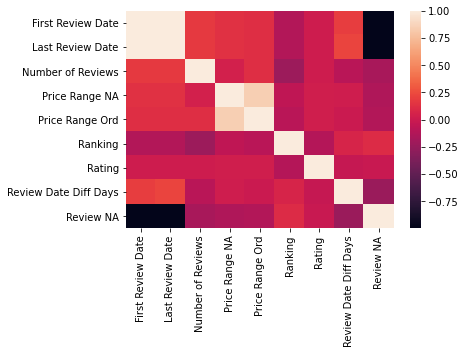

In [206]:
sns.heatmap(processed_data[[
    'First Review Date', 'Last Review Date', 'Number of Reviews',
    'Price Range NA', 'Price Range Ord', 'Ranking', 'Rating',
    'Review Date Diff Days', 'Review NA'
]].corr())

# Train / test data split

In [175]:
train_data = processed_data.query('sample == 1').drop(['sample'], axis=1)
test_data = processed_data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values
X = train_data.drop(['Rating'], axis = 1)

In [21]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [176]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Model training

In [23]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [177]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

<AxesSubplot:>

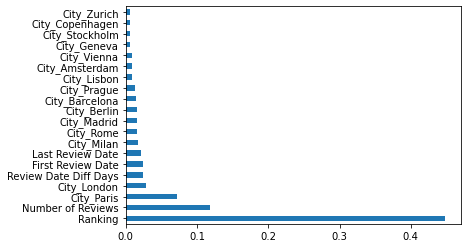

In [72]:
# check the most used features
f_imp = pd.Series(regr.feature_importances_, index=X.columns)
f_imp.nlargest(20).plot(kind='barh')

In [178]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.210013


## SUBMISSION

In [180]:
test_data = test_data.drop(['Rating'], axis=1)

In [181]:
predict_submission = regr.predict(test_data)

In [185]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('my_submission.csv', index=False)

In [194]:
sample_submission.sample(4)

,Restaurant_id,Rating
514,id_514,2.5
665,id_665,1.0
7812,id_7812,2.5
2665,id_2665,2.5
